<a href="https://colab.research.google.com/github/ssmehra7/curvetopia-adobe_gensolve/blob/main/Symmetry_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"This algorithm takes .png file as input and peerforms symmetry detection on it and gives png file with line of symmetry as output "

In [ ]:
"you can use the following residual code to conver polylines to png and svg formats and save it in the runtime"

In [ ]:
!pip install svgwrite cairosvg pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import svgwrite
import cairosvg
from PIL import Image

# Define the colors used for the polylines
colours = ['#000000']  # Adjust this as needed, currently set to black for grayscale

def polylines2svg(paths_XYs, svg_path):
    W, H = 0, 0
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W, H = max(W, np.max(XY[:, 0])), max(H, np.max(XY[:, 1]))
    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)

    # Create a new SVG drawing with specified size
    dwg = svgwrite.Drawing(svg_path, profile='tiny', size=(W, H), shape_rendering='crispEdges')
    group = dwg.g()

    for i, path in enumerate(paths_XYs):
        path_data = []
        c = colours[i % len(colours)]
        for XY in path:
            path_data.append(("M", (XY[0, 0], XY[0, 1])))
            for j in range(1, len(XY)):
                path_data.append(("L", (XY[j, 0], XY[j, 1])))
        group.add(dwg.path(d=path_data, fill='none', stroke=c, stroke_width=2))

    dwg.add(group)
    dwg.save()

    png_path = svg_path.replace('.svg', '.png')
    fact = max(1, 1024 // min(H, W))

    # Convert the SVG to PNG
    cairosvg.svg2png(url=svg_path, write_to=png_path, output_width=fact*W, output_height=fact*H, background_color='white')

    # Convert the PNG to grayscale
    img = Image.open(png_path).convert('L')
    img.save(png_path)
    return png_path

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []

    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)

    return path_XYs

# Example usage
csv_path = '/content/occlusion.csv'
paths_XYs = read_csv(csv_path)
svg_path = 'polylines.svg'
png_path = polylines2svg(paths_XYs, svg_path)
print(f"Saved grayscale PNG to {png_path}")


Saved grayscale PNG to polylines.png


Maximum density at r: 403.85, theta: -0.34 radians


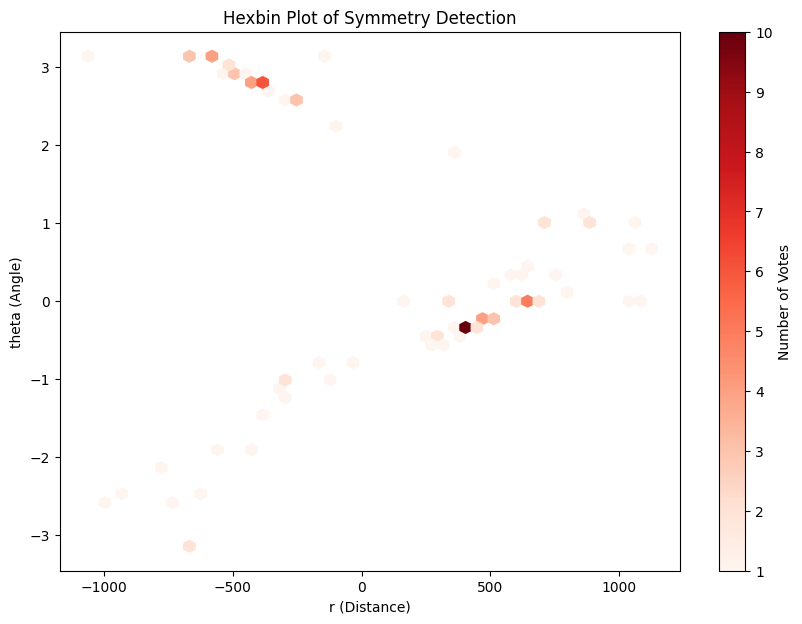

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Define the required functions
def very_close(pt1, pt2, threshold=5.0):
    """Returns True if the two points are within a certain threshold distance."""
    return np.linalg.norm(np.array(pt1) - np.array(pt2)) < threshold

def angle_with_x_axis(pt1, pt2):
    """Calculates the angle of the line connecting pt1 and pt2 with the x-axis."""
    dx = pt2[0] - pt1[0]
    dy = pt2[1] - pt1[1]
    return np.arctan2(dy, dx)

def midpoint(pt1, pt2):
    """Calculates the midpoint between two points."""
    return ( (pt1[0] + pt2[0]) / 2, (pt1[1] + pt2[1]) / 2 )

def reisfeld(angle1, angle2, theta):
    """Computes the Reisfeld measure for symmetry."""
    return 1 - np.cos(2 * (angle1 - angle2 - theta))

def S(size1, size2):
    """Computes the scale factor for symmetry detection."""
    return min(size1, size2) / max(size1, size2)

def superm2(image):
    """Performs the symmetry detection on image and plots the hexbin plot."""
    mimage = np.fliplr(image)
    kp1, des1 = sift.detectAndCompute(image, None)
    kp2, des2 = sift.detectAndCompute(mimage, None)
    for p, mp in zip(kp1, kp2):
        p.angle = np.deg2rad(p.angle)
        mp.angle = np.deg2rad(mp.angle)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    houghr = []
    houghth = []
    weights = []
    good = []

    for match, match2 in matches:
        point = kp1[match.queryIdx]
        mirpoint = kp2[match.trainIdx]
        mirpoint2 = kp2[match2.trainIdx]
        mirpoint2.angle = np.pi - mirpoint2.angle
        mirpoint.angle = np.pi - mirpoint.angle
        if mirpoint.angle < 0.0:
            mirpoint.angle += 2 * np.pi
        if mirpoint2.angle < 0.0:
            mirpoint2.angle += 2 * np.pi
        mirpoint.pt = (mimage.shape[1] - mirpoint.pt[0], mirpoint.pt[1])
        if very_close(point.pt, mirpoint.pt):
            mirpoint = mirpoint2
            good.append(match2)
        else:
            good.append(match)
        theta = angle_with_x_axis(point.pt, mirpoint.pt)
        xc, yc = midpoint(point.pt, mirpoint.pt)
        r = xc * np.cos(theta) + yc * np.sin(theta)
        Mij = reisfeld(point.angle, mirpoint.angle, theta) * S(
            point.size, mirpoint.size
        )
        houghr.append(r)
        houghth.append(theta)
        weights.append(Mij)

    houghr = np.array(houghr)
    houghth = np.array(houghth)
    weights = np.array(weights)

    # Plotting the hexbin plot with interactivity
    def hex_plot():
        fig, ax = plt.subplots(figsize=(10, 7))
        hb = ax.hexbin(houghr, houghth, gridsize=50, cmap='Reds', mincnt=1)
        plt.title('Hexbin Plot of Symmetry Detection')
        plt.xlabel('r (Distance)')
        plt.ylabel('theta (Angle)')
        cb = plt.colorbar(hb, ax=ax, label='Number of Votes')

        # Find the hexbins with the highest density (darkest color)
        max_counts_idx = np.argmax(hb.get_array())
        r_val = hb.get_offsets()[max_counts_idx][0]
        theta_val = hb.get_offsets()[max_counts_idx][1]

        print(f"Maximum density at r: {r_val:.2f}, theta: {theta_val:.2f} radians")

        plt.show()

    hex_plot()

# Example usage
if __name__ == "__main__":
    image = cv2.imread('/content/polylines.png', 0)  # Replace with your image path
    sift = cv2.SIFT_create()  # Initialize SIFT detector
    superm2(image)


In [ ]:
"plot the above hex plot for different png files and accordingly use the values of r and theta in further example"

In [ ]:
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np

sift = cv2.SIFT_create()


def very_close(a, b, tol=4.0):
    """Checks if the points a, b are within
    tol distance of each other."""
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) < tol


def S(si, sj, sigma=1):
    """Computes the 'S' function mentioned in
    the research paper."""
    q = (-abs(si - sj)) / (sigma * (si + sj))
    return np.exp(q ** 2)


def reisfeld(phi, phj, theta):
    return 1 - np.cos(phi + phj - 2 * theta)


def midpoint(i, j):
    return (i[0] + j[0]) / 2, (i[1] + j[1]) / 2


def angle_with_x_axis(i, j):
    x, y = i[0] - j[0], i[1] - j[1]
    if x == 0:
        return np.pi / 2
    angle = np.arctan(y / x)
    if angle < 0:
        angle += np.pi
    return angle


def superm2(image):
    """Performs the symmetry detection on image."""
    mimage = np.fliplr(image)
    kp1, des1 = sift.detectAndCompute(image, None)
    kp2, des2 = sift.detectAndCompute(mimage, None)
    for p, mp in zip(kp1, kp2):
        p.angle = np.deg2rad(p.angle)
        mp.angle = np.deg2rad(mp.angle)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    houghr = np.zeros(len(matches))
    houghth = np.zeros(len(matches))
    weights = np.zeros(len(matches))
    i = 0
    good = []
    for match, match2 in matches:
        point = kp1[match.queryIdx]
        mirpoint = kp2[match.trainIdx]
        mirpoint2 = kp2[match2.trainIdx]
        mirpoint2.angle = np.pi - mirpoint2.angle
        mirpoint.angle = np.pi - mirpoint.angle
        if mirpoint.angle < 0.0:
            mirpoint.angle += 2 * np.pi
        if mirpoint2.angle < 0.0:
            mirpoint2.angle += 2 * np.pi
        mirpoint.pt = (mimage.shape[1] - mirpoint.pt[0], mirpoint.pt[1])
        if very_close(point.pt, mirpoint.pt):
            mirpoint = mirpoint2
            good.append(match2)
        else:
            good.append(match)
        theta = angle_with_x_axis(point.pt, mirpoint.pt)
        xc, yc = midpoint(point.pt, mirpoint.pt)
        r = xc * np.cos(theta) + yc * np.sin(theta)
        Mij = reisfeld(point.angle, mirpoint.angle, theta) * S(
            point.size, mirpoint.size
        )
        houghr[i] = r
        houghth[i] = theta
        weights[i] = Mij
        i += 1
    # matches = sorted(matches, key = lambda x:x.distance)
    good = sorted(good, key=lambda x: x.distance)

    def draw(r, theta):
        if np.pi / 4 < theta < 3 * (np.pi / 4):
            for x in range(len(image.T)):
                y = int((r - x * np.cos(theta)) / np.sin(theta))
                if 0 <= y < len(image.T[x]):
                    image[y][x] = 100
        else:
            for y in range(len(image)):
                x = int((r - y * np.sin(theta)) / np.cos(theta))
                if 0 <= x < len(image[y]):
                    image[y][x] = 100

    img3 = cv2.drawMatches(image, kp1, mimage, kp2, good[:15], None, flags=2)
    # print(*(m.distance for m in matches[:10]))
    # cv2.imshow('a',img3); cv2.waitKey(0);


    draw(r, theta)
    cv2.imshow('a', image); cv2.waitKey(0);


def draw(image, r, theta):
    if np.pi / 4 < theta < 3 * (np.pi / 4):
        for x in range(len(image.T)):
            y = int((r - x * np.cos(theta)) / np.sin(theta))
            if 0 <= y < len(image.T[x]):
                image[y][x] = 100
    else:
        for y in range(len(image)):
            x = int((r - y * np.sin(theta)) / np.cos(theta))
            if 0 <= x < len(image[y]):
                image[y][x] = 100


def main():
    argc = len(sys.argv)
    if not (argc == 2 or argc == 4 or argc == 5):
        print("Usage: python3 detect.py IMAGE [r] [theta]")
        return
    if argc == 2:
        superm2(cv2.imread(sys.argv[1], 0))
    elif argc == 4:
        image = cv2.imread(sys.argv[1], 0)
        draw(image, float(sys.argv[2]), float(sys.argv[3]))
        cv2.imshow("a", image)
        cv2.waitKey(0)
    else:
        image = cv2.imread(sys.argv[1], 0)
        draw(image, float(sys.argv[2]), float(sys.argv[3]))
        cv2.imwrite("{}".format(sys.argv[4]), image)


if __name__ == "__main__":
    main()

Usage: python3 detect.py IMAGE [r] [theta]


In [ ]:
"writing the above file as detect.py and saving it in the runtime."

'writing the above file as detect.py and saving it in the runtime.'

In [ ]:
%%writefile detect.py
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np

sift = cv2.SIFT_create()


def very_close(a, b, tol=4.0):
    """Checks if the points a, b are within
    tol distance of each other."""
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) < tol


def S(si, sj, sigma=1):
    """Computes the 'S' function mentioned in
    the research paper."""
    q = (-abs(si - sj)) / (sigma * (si + sj))
    return np.exp(q ** 2)


def reisfeld(phi, phj, theta):
    return 1 - np.cos(phi + phj - 2 * theta)


def midpoint(i, j):
    return (i[0] + j[0]) / 2, (i[1] + j[1]) / 2


def angle_with_x_axis(i, j):
    x, y = i[0] - j[0], i[1] - j[1]
    if x == 0:
        return np.pi / 2
    angle = np.arctan(y / x)
    if angle < 0:
        angle += np.pi
    return angle


def superm2(image):
    """Performs the symmetry detection on image.
   """
    mimage = np.fliplr(image)
    kp1, des1 = sift.detectAndCompute(image, None)
    kp2, des2 = sift.detectAndCompute(mimage, None)
    for p, mp in zip(kp1, kp2):
        p.angle = np.deg2rad(p.angle)
        mp.angle = np.deg2rad(mp.angle)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    houghr = np.zeros(len(matches))
    houghth = np.zeros(len(matches))
    weights = np.zeros(len(matches))
    i = 0
    good = []
    for match, match2 in matches:
        point = kp1[match.queryIdx]
        mirpoint = kp2[match.trainIdx]
        mirpoint2 = kp2[match2.trainIdx]
        mirpoint2.angle = np.pi - mirpoint2.angle
        mirpoint.angle = np.pi - mirpoint.angle
        if mirpoint.angle < 0.0:
            mirpoint.angle += 2 * np.pi
        if mirpoint2.angle < 0.0:
            mirpoint2.angle += 2 * np.pi
        mirpoint.pt = (mimage.shape[1] - mirpoint.pt[0], mirpoint.pt[1])
        if very_close(point.pt, mirpoint.pt):
            mirpoint = mirpoint2
            good.append(match2)
        else:
            good.append(match)
        theta = angle_with_x_axis(point.pt, mirpoint.pt)
        xc, yc = midpoint(point.pt, mirpoint.pt)
        r = xc * np.cos(theta) + yc * np.sin(theta)
        Mij = reisfeld(point.angle, mirpoint.angle, theta) * S(
            point.size, mirpoint.size
        )
        houghr[i] = r
        houghth[i] = theta
        weights[i] = Mij
        i += 1
    # matches = sorted(matches, key = lambda x:x.distance)
    good = sorted(good, key=lambda x: x.distance)

    def draw(r, theta):
        if np.pi / 4 < theta < 3 * (np.pi / 4):
            for x in range(len(image.T)):
                y = int((r - x * np.cos(theta)) / np.sin(theta))
                if 0 <= y < len(image.T[x]):
                    image[y][x] = 100
        else:
            for y in range(len(image)):
                x = int((r - y * np.sin(theta)) / np.cos(theta))
                if 0 <= x < len(image[y]):
                    image[y][x] = 100

    img3 = cv2.drawMatches(image, kp1, mimage, kp2, good[:15], None, flags=2)
    # print(*(m.distance for m in matches[:10]))
    # cv2.imshow('a',img3); cv2.waitKey(0);

    draw(r, theta)
    cv2.imshow('a', image); cv2.waitKey(0);


def draw(image, r, theta):
    if np.pi / 4 < theta < 3 * (np.pi / 4):
        for x in range(len(image.T)):
            y = int((r - x * np.cos(theta)) / np.sin(theta))
            if 0 <= y < len(image.T[x]):
                image[y][x] = 100
    else:
        for y in range(len(image)):
            x = int((r - y * np.sin(theta)) / np.cos(theta))
            if 0 <= x < len(image[y]):
                image[y][x] = 100


def main():
    argc = len(sys.argv)
    if not (argc == 2 or argc == 4 or argc == 5):
        print("Usage: python3 detect.py IMAGE [r] [theta]")
        return
    if argc == 2:
        superm2(cv2.imread(sys.argv[1], 0))
    elif argc == 4:
        image = cv2.imread(sys.argv[1], 0)
        draw(image, float(sys.argv[2]), float(sys.argv[3]))
        cv2.imshow("a", image)
        cv2.waitKey(0)
    else:
        image = cv2.imread(sys.argv[1], 0)
        draw(image, float(sys.argv[2]), float(sys.argv[3]))
        cv2.imwrite("{}".format(sys.argv[4]), image)


if __name__ == "__main__":
    main()

Overwriting detect.py


In [ ]:
"use this ' !python3 detect.py input.png r theta output.png ' "

"use this ' !python3 detect.py input.png r theta output.png ' "

In [ ]:
"the above command will save the output as output .png file in the runtime with line of symmetry"

'the above command will save the output as output .png file in the runtime with line of symmetry'

In [ ]:
!python3 detect.py polylines.png  403.85 -0.34 output.png